Ali Al Kadhim and Harrison B. Prosper <br>
Department of Physics, Florida State University <br>


In [1]:
import numpy as np; import pandas as pd
import scipy as sp; import scipy.stats as st
import torch; import torch.nn as nn
from numba import njit
from sklearn.preprocessing import StandardScaler; from sklearn.model_selection import train_test_split
import matplotlib as mp; import matplotlib.pyplot as plt; plt.style.use('seaborn-deep')
mp.rcParams['agg.path.chunksize'] = 10000
# %matplotlib inline
import copy; import sys; import os
from IPython.display import Image, display
import optuna
#sometimes jupyter doesnt initialize MathJax automatically for latex, so do this
import ipywidgets as wid; wid.HTMLMath('$\LaTeX$')

HTMLMath(value='$\\LaTeX$')

In particle physics, the most important experiment is a counting experiment, represented by a Poisson probability model, where $N$ is the observed count and $\theta$ is a nuissance parameter, hence the probability model is $P(N|\theta) = \text{Poisson}(N,\theta)$.
where the most important parameter is the cross section $\sigma$, which is related to the mean event count $N = \sigma \mathcal{L} +b$. 


# For the two-parameter problem, the Poisson mean$=\theta+\nu$, and the probability model is given by

$$p(N,M|\theta, \nu) = \text{Poiss}(N; \theta+\nu)\text{Poiss}(M;\nu) =L(\theta, \nu)= \frac{e^{-(\theta+\nu)} (\theta+\nu)^N }{N !} \ \frac{e^{-\nu} \nu^M}{M !}$$



Where $\nu$ is the nuissance parameter, $\theta$ is the paramter of interest (for which we want to estimate upper limits). 


### Observed Data:

   * $N$ (counts for signal)
   * $M$ (counts for background)

### Parameters:

* $\theta$ (parameter of interest)

* $\nu$ (nuissance parameter)

### Auxiliary (simulated) Data (simulated on-the-fly for each observation)

* $n$

* $m$


    
The standard procedure for removal of nuissance parameters is Bayesian marginalization, but in this study we adopt LFI with frequentest methods.

In this notebook we generate data comprising the quadruplets $(Z_i, \theta_i, \nu_i, N_i, M_i)$ where 

$
\begin{align}
\theta & \sim \textrm{uniform}(0, 20), \\
\nu & \sim \textrm{uniform}(0, 20), \\
n & \sim \textrm{poisson}(\theta + \nu),\\
m & \sim \textrm{poisson}(\nu),\\
N & \sim \textrm{uniform}(0,10),\\
M & \sim \textrm{uniform}(0, 10), \textrm{ and } \\
Z & = I[ \lambda_{\textrm{gen}} \leq \lambda_D (D, \theta) ],
\end{align}
$

where the size of each of these samples is $B'$, $I$ is the indicator function, and $\lambda_D (D, \theta)= \lambda(N, M, \theta)$ is our chosen test statistic

$$ \lambda = - 2 \log{\frac{p(n,m|\theta, \hat{\nu}(\theta) )}{ p(n,m|\hat{\theta}, \hat{\nu}(\theta) )}} = -2 \log \frac{L_{\text{prof}} \big(n, m, \theta, \hat{\nu}(\theta) \big) }{L_{\text{prof}} \big( n, m, \hat{\theta}_{\text{MLE}}, \hat{\nu}(\theta) \big)}$$

Where $L_{\text{prof}} (n, m, \theta, \hat{\nu}(\theta))$ is the profiled likelihood. The maximum likelihood estimate of $\hat{\theta}$, 
$$\hat{\theta}_{\text{MLE}}=n-m$$, and

$$\log{p(n,m|\theta,\nu)} = -(\theta+\nu)+n\log{(\theta+\nu)|-\nu+m\log{\nu}} + \text{constants}$$
The MLE $\hat{\nu}(\theta)$ is attained by solving $\frac{\partial \log{p(n,m|\theta,\nu)}}{ \partial \nu} =0$ leading to 

$$\hat{\nu}(\theta)=\left(g+\sqrt{g^2 + 8 m \theta} \right)/4$$
where $g \equiv n+m-2 \theta$.

And since $\nu$ has been marginalized in the likelihood, $\lambda$ only depends on $\theta,\n,m$ (but is used as a test statistic for $\theta$ only), and is only "slighly" dependent on $n,m$ since they're really not the observed data but instead simulations on the fly. $\lambda=\lambda(\theta,n,m)$

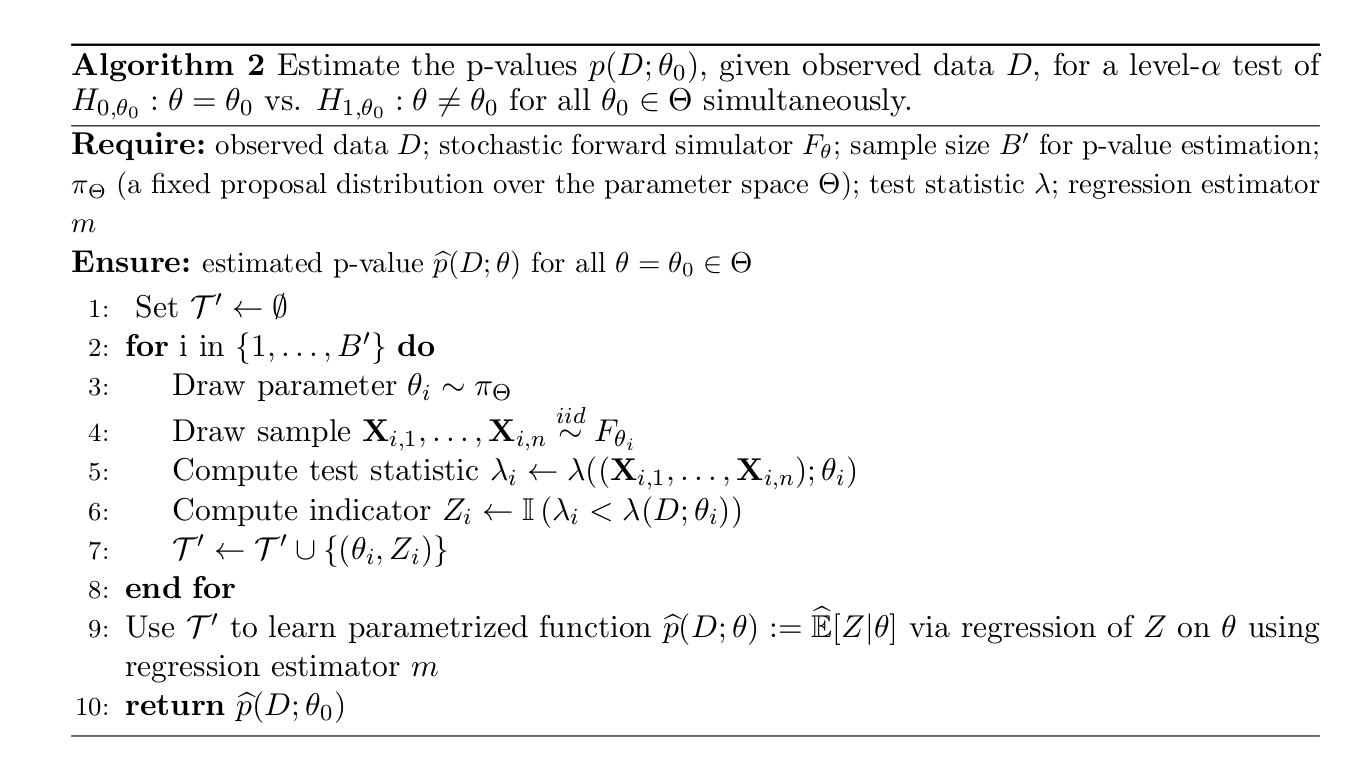

In [2]:
algorithm2 = Image('images/Algorithm2.jpg'); display(algorithm2)

In [3]:
def mkdir(dir_):
    """make a directory without overwriting what's in it if it exists"""
    # assert isinstance(dir_, str)
    try:
        os.system('mkdir -p %s' % str(dir_) )
    except Exception:
        pass

In [4]:
mkdir('utils')

In [4]:
# %writefile 'src/utils.py'

def import_base_stack():
    import numpy as np; import pandas as pd
    import scipy as sp; from numba import njit

@njit
def DR(s, theta):
    return sp.special.gammainc(s, theta)

@njit
def DL(s, theta):
    return 1 - sp.special.gammainc(s+1, theta)


def L_prof(n,m,theta):
    k=1
    k1 = k+1
    k2 = 0.5/k1
    g = n+m - k1*theta
    nu_hat = k2* (g+ np.sqrt(g*g +4*k1*m*theta))
    p1 = st.poisson.pmf(n, mu = theta + nu_hat)
    p2 = st.poisson.pmf(m, mu = k * nu_hat)
    
    return p1*p2


def theta_hat(n,m, MLE=True):
    theta_hat = n-m
    
    if not MLE:
        theta_hat = theta_hat * (theta_hat > 0)
    return theta_hat

# @njit
def lambda_test(theta, n, m, MLE=True):
    Ln = L_prof(n,m,theta)
    Ld = L_prof(n,m, theta_hat(n,m, MLE))
    lambda_  = -2*np.log(Ln/Ld)
    return np.array(lambda_)

In [5]:
chi2_exp_size=40

def run_sim(theta, nu, MLE, lambda_size):
    """Sample n ~ Pois(theta+nu), 
              m ~ Pois(nu), 
    and compute 
              lambda(theta, n, m)
              
    return: (n, m, lambda_), where each are np arrays of length lambda_size
    """
    n = st.poisson.rvs(theta+nu, size=lambda_size)
    m = st.poisson.rvs(nu, size=lambda_size)
    lambda_ = lambda_test(theta, n, m, MLE=MLE)
    return (n, m, lambda_)

def run_sims(points, MLE):
    """
    Run an entire simulation, that is, generate n and m from 
    run_sim above, and calculate lambda, for
    
    input: a tuple of (theta, nu) scalars
    
    Reurns:df, lambda_results
    
    where lambda_results is a list of tuples 
        (n, m, lambda_, theta, nu)
    and df is just a dataframe of [n,m,lambda,theta,nu]

    """
    lambda_results=[]
    df=pd.DataFrame()
    for p in points:
        theta, nu = p
        df['theta']=theta
        df['nu']=nu
        n, m, lambda_ = run_sim(theta, nu, MLE, lambda_size =chi2_exp_size)
        df['n'] = n
        df['m'] = m
        df['lambda']=lambda_
        lambda_results.append((n, m, lambda_, theta, nu))
    
        print( '\n \n (theta, nu) =  (%.f, %.f) \n ' % (theta, nu) )
        print(f'\t \t with associated n =  {n}, \n \n \t \t m = {m}, \n \n \t \t lambda = {lambda_}'  )
    return df, lambda_results

def plot_one(lambda_, theta, nu, ax):
    """Histogram the CDF of  lambda_t = -2log(Lp(theta)/Lp(theta_hat)), 
    for a given (fixed) theta and nu.
    Also, plot the actual CDF of a chi^2 distribution with 1 free parameter 
    (since only theta is left after we profile nu) """
    ftsize = 16; xmin= 0; xmax= 10
    ymin= 0; ymax= 1
    x_range = (xmin, xmax)
    y_range = (ymin, ymax)
    ax.set_xlim(x_range); ax.set_ylim(y_range)
    ax.set_xlabel(r'$\lambda (\theta, n, m, \hat{\nu}(\theta))$',fontsize=ftsize)
    ax.set_ylabel(r'cdf$(\lambda)$', fontsize=ftsize)
    ##########HISTOGRAM CDF OF LAMBDA####################
    ax.hist(lambda_, bins=5*xmax, range=x_range,
    color=(0.8,0.8,0.9),
    density=True, cumulative=True,
    histtype='stepfilled', edgecolor='black', label=r'CDF$(\lambda)$')
    ############################################################
    ########### HISTOGRAM CDF OF THE CHI2 OF OF X WITH 1 DOF
    #x is not theta, that's the whole point of Wilks thm, x is an arbitrary RV
    x = np.arange(0, xmax, 0.2)
    y = st.chi2.cdf(x, 1)
    ax.plot(x, y, color='blue',
    linewidth=2, label=r'CDF$(\chi^2_1)$')
    # annotate
    xwid = (xmax-xmin)/12
    ywid = (ymax-ymin)/12
    xpos = xmin + xwid/2
    ypos = ymin + ywid*2
    ax.text(xpos, ypos,
    r'$ \theta = %d, \nu = %d$' % (theta, nu),
    fontsize=ftsize)
    ax.legend(loc='upper right',fontsize=10)

1. Generate one scalar $\theta$ and one scalar $\nu$
2. Generate $\lambda(\theta,\nu)$ of size $N$, the distribution of this $\lambda$ will approach the CDF of a $\chi^2_{dof}(x)$ of an RV of one dof (since $\theta$ is the only free parameter left)
4. Observe that this test statistc will be dependent on the value of $\nu$ in the non-MLE case, which is not desirable since we want to be insensetive to nuissance parameters for maximal statistal power


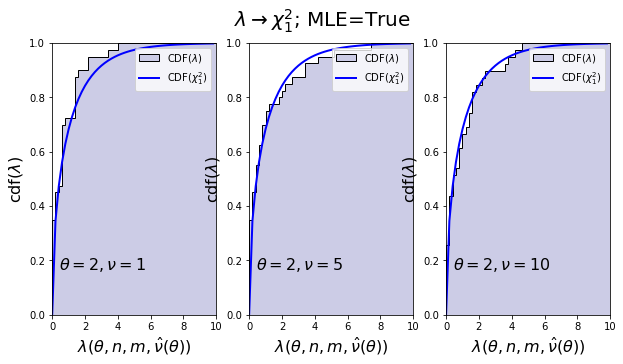

In [6]:
#points=(theta,nu)
points_1 = (2, 1)
points_2 = (2, 5)
points_3 = (2, 10)
MLE=True
_, _ , lambda_1 = run_sim(theta=points_1[0], nu=points_1[1], MLE=MLE, lambda_size=chi2_exp_size)
_, _ , lambda_2 = run_sim(theta=points_2[0], nu=points_2[1], MLE=MLE, lambda_size=chi2_exp_size)
_, _ , lambda_3 = run_sim(theta=points_3[0], nu=points_3[1], MLE=MLE, lambda_size=chi2_exp_size)

fig, ax = plt.subplots(1,3, figsize=(10,5))
plot_one(lambda_1, points_1[0], points_1[1], ax[0])
plot_one(lambda_2, points_2[0], points_2[1], ax[1])
plot_one(lambda_3, points_3[0], points_3[1], ax[2])
fig.suptitle(r'$\lambda \rightarrow \chi^2_1$; MLE=%s' % str(MLE), fontsize=20); plt.show()

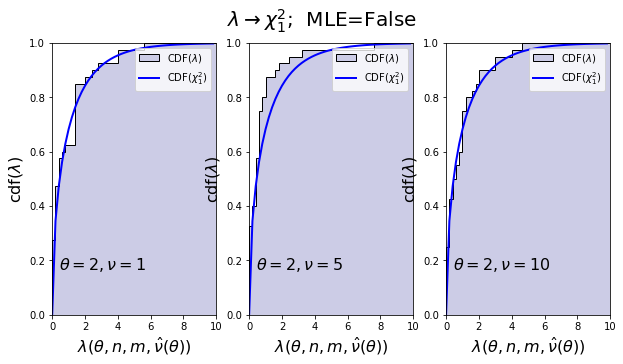

In [36]:
#points=(theta,nu)
points_1 = (2, 1)
points_2 = (2, 5)
points_3 = (2, 10)
MLE=False
_, _ , lambda_1 = run_sim(theta=points_1[0], nu=points_1[1], MLE=MLE, lambda_size=chi2_exp_size)
_, _ , lambda_2 = run_sim(theta=points_2[0], nu=points_2[1], MLE=MLE, lambda_size=chi2_exp_size)
_, _ , lambda_3 = run_sim(theta=points_3[0], nu=points_3[1], MLE=MLE, lambda_size=chi2_exp_size)

fig, ax = plt.subplots(1,3, figsize=(10,5))
plot_one(lambda_1, points_1[0], points_1[1], ax[0])
plot_one(lambda_2, points_2[0], points_2[1], ax[1])
plot_one(lambda_3, points_3[0], points_3[1], ax[2])
fig.suptitle(r'$\lambda \rightarrow \chi^2_1$;  MLE=False', fontsize=20); plt.show()

Generate 6 pairs (tuples) of $(\theta, \nu)$ values

In [7]:
points = [(theta, nu) for theta, nu in 
          zip(np.random.randint(low=1,high=4,size=3), 
              np.random.randint(low=0,high=4,size=3))]

In [8]:
df, results = run_sims(points, MLE=True)


 
 (theta, nu) =  (2, 0) 
 
	 	 with associated n =  [2 5 4 3 1 3 2 0 1 1 1 2 1 1 2 4 1 1 2 3 1 1 3 3 1 4 3 2 1 3 4 2 2 3 0 3 2
 0 3 2], 
 
 	 	 m = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0], 
 
 	 	 lambda = [-0.          2.93147181  1.54517744  0.43279065  0.61370564  0.43279065
 -0.          4.          0.61370564  0.61370564  0.61370564 -0.
  0.61370564  0.61370564 -0.          1.54517744  0.61370564  0.61370564
 -0.          0.43279065  0.61370564  0.61370564  0.43279065  0.43279065
  0.61370564  1.54517744  0.43279065 -0.          0.61370564  0.43279065
  1.54517744 -0.         -0.          0.43279065  4.          0.43279065
 -0.          4.          0.43279065 -0.        ]

 
 (theta, nu) =  (2, 3) 
 
	 	 with associated n =  [5 9 5 9 3 6 4 4 6 2 8 4 4 5 2 7 5 3 5 4 6 5 5 8 7 4 6 2 5 2 4 7 4 5 7 4 4
 3 9 8], 
 
 	 	 m = [3 4 6 5 4 1 5 3 5 4 6 8 5 5 3 2 4 5 3 5 5 3 3 0 4 9 2 4 4 3 5 2 0 1 4 2 3
 3 2 2], 
 
 	 	 lambda = [-0.          0.71

In [9]:
df.head()

,theta,nu,n,m,lambda
0,1,0,2,0,0.772589
1,1,0,0,0,2.000000
2,1,0,0,0,2.000000
3,1,0,1,0,-0.000000
4,1,0,1,0,-0.000000


In [10]:
n, m, lambda_, theta, nu =results[1]
print(f'results[1] =  (n1, m1, lambda1, theta1, nu1) =  (  \n {n}, \n {m}, \n {lambda_}, \n {theta}, \n {nu})' )
print(f'''\n (n.shape, m.shape, lambda_.shape, theta.size, nu.size) = 
      ({n.shape}, \t {m.shape}, \t {lambda_.shape}, \t {theta.size}, \t {nu.size})''')

results[1] =  (n1, m1, lambda1, theta1, nu1) =  (  
 [5 9 5 9 3 6 4 4 6 2 8 4 4 5 2 7 5 3 5 4 6 5 5 8 7 4 6 2 5 2 4 7 4 5 7 4 4
 3 9 8], 
 [3 4 6 5 4 1 5 3 5 4 6 8 5 5 3 2 4 5 3 5 5 3 3 0 4 9 2 4 4 3 5 2 0 1 4 2 3
 3 2 2], 
 [-0.          0.7165121   0.80229178  0.29075642  1.2288131   1.47928694
  0.97179616  0.1396362   0.09005222  2.51359335 -0.          2.96578989
  0.97179616  0.39239727  1.66020193  1.07969347  0.10956358  1.92861676
 -0.          0.97179616  0.09005222 -0.         -0.          7.09035489
  0.09206738  3.7531945   0.52939123  2.51359335  0.10956358  1.66020193
  0.97179616  1.07969347  1.54517744  0.74478362  0.09206738 -0.
  0.1396362   0.63419698  2.52578322  1.75504047], 
 2, 
 3)

 (n.shape, m.shape, lambda_.shape, theta.size, nu.size) = 
      ((40,), 	 (40,), 	 (40,), 	 1, 	 1)


### Generate Training data (or take a look at the saved training data)

In [134]:
train_df = pd.read_csv('data/two_parameters_theta_0_20_1000k_Examples_MLE_True.csv')
train_df.describe()

,Unnamed: 0,Z,theta,nu,N,M
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,499999.500000,0.869850,10.001455,9.996543,4.999657,4.999906
std,288675.278933,0.336469,5.768938,5.774471,2.580935,2.582730
min,0.000000,0.000000,0.000011,0.000046,1.000000,1.000000
25%,249999.750000,1.000000,5.012122,4.994961,3.000000,3.000000
50%,499999.500000,1.000000,10.003773,9.988105,5.000000,5.000000
75%,749999.250000,1.000000,14.997117,14.992853,7.000000,7.000000
max,999999.000000,1.000000,19.999996,19.999982,9.000000,9.000000


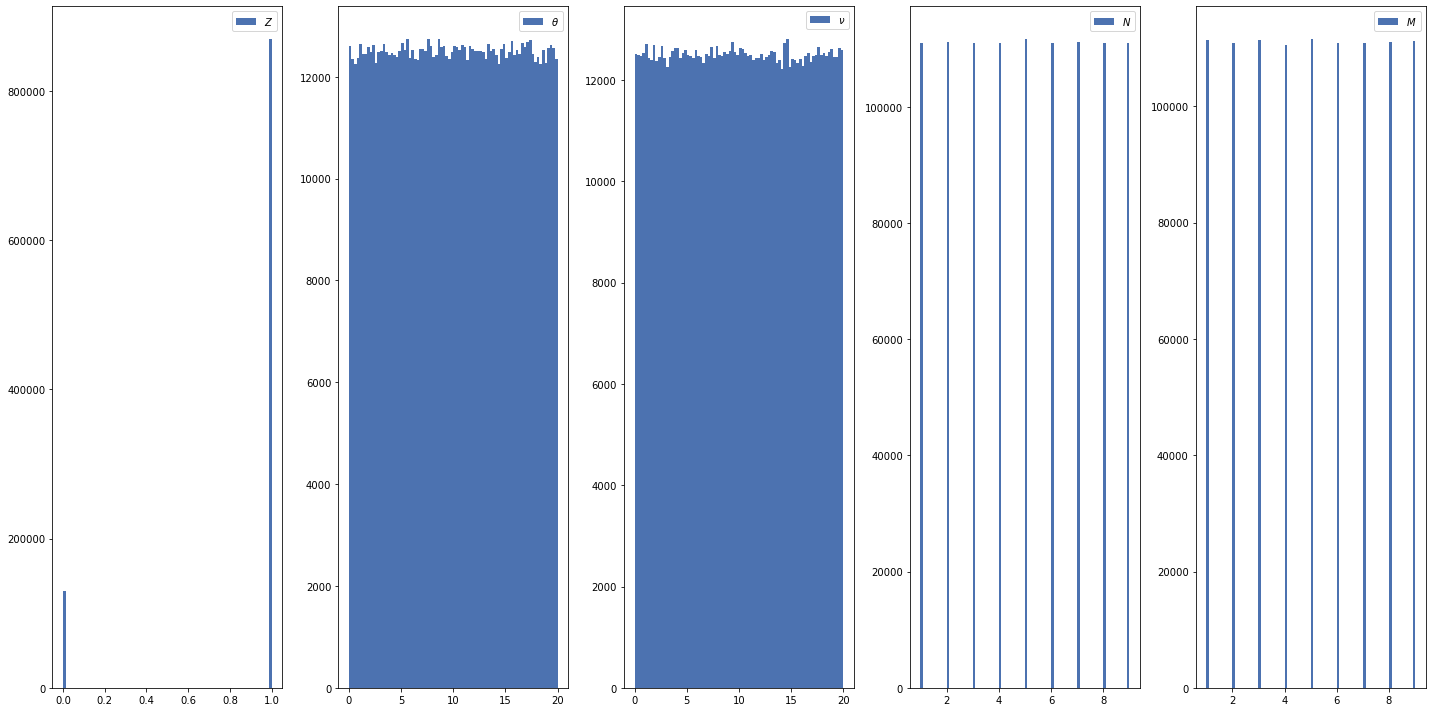

In [148]:
bins_ = 80
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,10))
ax[0].hist(train_df['Z'], bins=bins_, label=r'$Z$')
ax[1].hist(train_df['theta'], bins=bins_, label=r'$\theta$')
ax[2].hist(train_df['nu'], bins=bins_, label=r'$\nu$')
ax[3].hist(train_df['N'], bins=bins_, label=r'$N$')
ax[4].hist(train_df['M'], bins=bins_, label=r'$M$')

[ax[i].legend() for i in range(5)]
plt.tight_layout(); plt.show()

## Generate data according to:

$
\begin{align}
\theta & \sim \textrm{uniform}(0, 20), \\
\nu & \sim \textrm{uniform}(0, 20), \\
n & \sim \textrm{poisson}(\theta + \nu),\\
m & \sim \textrm{poisson}(\nu),\\
N & \sim \textrm{uniform}(0,10),\\
M & \sim \textrm{uniform}(0, 10), \textrm{ and } \\
Z & = I[ \lambda_{\textrm{gen}} \leq \lambda_D (D, \theta) ],
\end{align}
$

In [12]:
thetaMin, thetaMax =  0, 20
numin, numax = 0, 20
Nmin, Nmax =  1,10
Mmin, Mmax =  1 , 10

def generate_training_data(Bprime, MLE, save_data=False):
    """Generate the training data, that is, features=[theta, nu, N, M], targets=Z"""
    #sample theta and nu from uniform(0,20)
    theta = st.uniform.rvs(thetaMin, thetaMax, size=Bprime)
    # nu = st.uniform.rvs(nuMin, nuMax, size=Bprime)
    nu= st.uniform.rvs(numin, numax, size=Bprime)
    #n,m ~ F_{\theta,\nu}, ie our simulator. sample n from a Poisson with mean theta+nu 
    n = st.poisson.rvs(theta+ nu, size=Bprime)
    #sample m from a poisson with mean nu
    m = st.poisson.rvs(nu, size=Bprime)
    #sample our observed counts (N,M), which take the place of D
    N = np.random.randint(Nmin, Nmax, size=Bprime)
    M = np.random.randint(Mmin, Mmax, size=Bprime)
    SUBSAMPLE=10
    print('n=', n[:SUBSAMPLE])
    print('m=', m[:SUBSAMPLE])
    print('N=', N[:SUBSAMPLE])
    print('M=', M[:SUBSAMPLE])
    lambda_gen = lambda_test(theta, n, m, MLE)
    print('lambda_gen= ', lambda_gen[:SUBSAMPLE])
    lambda_D = lambda_test(theta, N, M, MLE)
    print('lambda_D= ', lambda_D[:SUBSAMPLE])
    #if lambda_gen <= lambda_D: Z=1, else Z=0
    Z = (lambda_gen <= lambda_D).astype(np.int32)
    
    data_2_param = {'Z' : Z, 'theta' : theta, 'nu': nu, 'N':N, 'M':M}

    data_2_param = pd.DataFrame.from_dict(data_2_param)
    if save_data:
        data_2_param.to_csv('data/two_parameters_theta_%s_%s_%sk_Examples_MLE_%s.csv' %\
                            (str(thetaMin), str(thetaMax), str(int(Bprime/1000)), str(MLE)) )

    print('\n')
    print(data_2_param.describe())
    return data_2_param

In [204]:
Train_data_MLE_True = generate_training_data(Bprime=1000000, MLE=True, save_data=True)

n= [28 35 20 13 24 24 15 31 16 16]
m= [11 22 12  5  7 17 11 18  7  1]
N= [4 7 1 3 6 8 9 3 1 2]
M= [2 3 1 6 7 2 3 9 8 2]
lambda_gen=  [3.70607949e-01 1.17306971e-01 2.29524861e-03 1.26705400e-04
 2.06437789e-01 4.29029536e-02 3.65333015e+00 3.36025114e-01
 1.10193257e-01 4.73885761e-02]
lambda_D=  [1.10574637e+01 3.24159209e+00 1.06254377e+01 1.04749261e+01
 2.05565938e+01 1.06437590e-02 4.27760452e+00 1.52823960e+01
 2.49336441e+01 2.20492624e+01]


                    Z           theta              nu               N  \
count  1000000.000000  1000000.000000  1000000.000000  1000000.000000   
mean         0.869850       10.001455        9.996543        4.999657   
std          0.336469        5.768938        5.774471        2.580935   
min          0.000000        0.000011        0.000046        1.000000   
25%          1.000000        5.012122        4.994961        3.000000   
50%          1.000000       10.003773        9.988105        5.000000   
75%          1.000000       14.9971

-----------


# Write Custom Data Loader

In [13]:
# %writefile data/dataloader.py

def split_t_x(df, target, source):
    # change from pandas dataframe format to a numpy 
    # array of the specified types
    t = np.array(df[target])
    x = np.array(df[source])
    return t, x

def load_df(df_name):
    """ returns the dataframe, can be used if the dataframe is saved in csv format
    of if it is already in dataframe format (e.g. generated in this notebook). """
    SUBSAMPLE=int(1e5)
    if isinstance(df_name,str):
        df = pd.read_csv('data/two_parameters_theta_0_20_1000k_Examples_MLE_True.csv', 
                         # nrows=SUBSAMPLE,
                         usecols=['Z','theta','nu', 'N', 'M']
                        )
    else:
        df = df_name#[:SUBSAMPLE]
    return df

def get_batch(x, batch_size):
    # the numpy function choice(length, number)
    # selects at random "batch_size" integers from 
    # the range [0, length-1] corresponding to the
    # row indices.
    rows    = np.random.choice(len(x), batch_size)
    batch_x = x[rows]
    # batch_x.T[-1] = np.random.uniform(0, 1, batch_size)
    return batch_x


def get_data_sets(simulate_data, batchsize):
    """write custom data generator because who wants to read pytorch's DataLoader source code
    (and its sometimes slow for some reason)"""
    # if simulate_data:
    #     Train_data_MLE_True = generate_training_data(Bprime=100000, MLE=True, save_data=False)
        
    # if SUBSAMPLE:
    #     data=load_df('data/TWO_PARAMETERS_TRAINING_DATA_1M.csv', SUBSAMPLE=10000)#This is MLE DATA!
    # else:
    #     data=load_df('data/TWO_PARAMETERS_TRAINING_DATA_1M.csv')
    # data=load_df('data/TWO_PARAMETERS_TRAINING_DATA_1M.csv')
    data = pd.read_csv('data/two_parameters_theta_0_20_1000k_Examples_MLE_True.csv', 
                 # nrows=SUBSAMPLE,
                 usecols=['Z','theta','nu', 'N', 'M']
                )
    train_data, test_data = train_test_split(data, 
                                         test_size=0.2)
    #split the train data (0.8 of whole set) again into 0.8*0.8=0.64 of whole set
    train_data, valid_data = train_test_split(train_data, test_size=0.2)
    train_data = train_data.reset_index(drop=True)
    valid_data = valid_data.reset_index(drop=True)
    test_data  = test_data.reset_index(drop=True)

    target='Z'
    source = ['theta','nu','N','M']
    train_t, train_x = split_t_x(train_data, target=target, source=source)
    valid_t, valid_x = split_t_x(valid_data, target=target, source=source)
    test_t,  test_x  = split_t_x(test_data,  target=target, source=source)
    
    def training_set_features():
            #start with an infinite loop, so that you can keep calling next (i.e. set = train_set(); set.next() ) until you run out of training examples
        while True:
            #get a random batch of the defined size
            batch_x = get_batch(train_x, batchsize)
            #print('batch_x', batch_x)
            #index of one of the items in our examples
            yield batch_x

    def evaluation_set_features():
        #start with an infinite loop, so that you can keep calling next (i.e. set = train_set(); set.next() ) until you run out of training examples
        while True:
            batch_x = get_batch(test_x,batchsize)
            #index of one of the items in our examples
            yield batch_x


    def training_set_targets():
            #start with an infinite loop, so that you can keep calling next (i.e. set = train_set(); set.next() ) until you run out of training examples
        while True:
            #get a random batch of the defined size
            batch_x = get_batch(train_t, batchsize)
            #print('batch_x', batch_x)
            #index of one of the items in our examples
            yield batch_x

    def evaluation_set_targets():
            #start with an infinite loop, so that you can keep calling next (i.e. set = train_set(); set.next() ) until you run out of training examples
        while True:
            #get a random batch of the defined size
            batch_x = get_batch(test_t, batchsize)
            #print('batch_x', batch_x)
            #index of one of the items in our examples
            yield batch_x

    return training_set_features, training_set_targets, evaluation_set_features, evaluation_set_targets

In [14]:
training_set_features, training_set_targets, evaluation_set_features, evaluation_set_targets = get_data_sets(simulate_data=True, batchsize=300)

first_features_batch = next(training_set_features())
print('first features batch \n', first_features_batch[:5])
print('\nfirst features batch shape \n', first_features_batch.shape)

first features batch 
 [[18.71969873 19.24172154  8.          6.        ]
 [18.53523329 15.11047839  9.          9.        ]
 [ 0.37094989  8.87669243  5.          5.        ]
 [17.34380938  9.17802071  2.          3.        ]
 [15.39976847  3.98600251  1.          7.        ]]

first features batch shape 
 (300, 4)


In [149]:
def binsize(data_df_or_Bprime):
    """ decide on the number of bins in a histogram according to Struge's rule"""
    if isinstance(data_df_or_Bprime,pd.core.frame.DataFrame):
        bin_count = int(np.ceil(np.log2(data_df_or_Bprime.shape[0])) + 1)
    elif isinstance(data_df_or_Bprime, int):
        bin_count = int(np.ceil(np.log2(data_df_or_Bprime)) + 1)
    return bin_count

Plot the histogrammed function the histogrammed function $h(\tilde{\theta}, \nu, N, M) = h(\theta_{min}, \theta_{max}, \nu, N, M)$ where $\tilde{\theta}$ means that it is simulated (inside the function).

In [16]:
def make_hist_data(Bprime,
              thetamin, thetamax,
              nu, N, M,
                nbins,
             MLE=True):

    theta = st.uniform.rvs(thetamin, thetamax, size=Bprime)
    n = st.poisson.rvs(theta + nu, size=Bprime)
    m = st.poisson.rvs(nu, size=Bprime)
    
    Z = (lambda_test(theta, n, m, MLE=MLE) < 
         lambda_test(theta, N, M, MLE=MLE)).astype(np.int32)

    thetarange = (thetamin, thetamax)
    # bins = binsize(Bprime)

    # weighted histogram   (count the number of ones per bin)
    y1, bb = np.histogram(theta, 
                          bins=nbins, 
                          range=thetarange, 
                          weights=Z)
    
    # unweighted histogram (count number of ones and zeros per bin)
    yt, _ = np.histogram(theta, 
                         bins=nbins, 
                         range=thetarange)

    y =  y1 / yt    
    
    return y, bb

In [17]:
h, h_bins = make_hist_data(Bprime=1000, 
                           thetamin=0,thetamax=20, 
                           nu=3,N=1,M=1,
                           nbins=200, MLE=True)
h

/home/ali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


array([0.125     , 0.        , 0.2       , 0.5       , 0.66666667,
       0.4       , 0.25      , 0.        , 0.25      , 0.28571429,
       0.66666667, 0.2       , 0.28571429, 1.        , 0.66666667,
       0.7       , 0.375     , 0.42857143, 0.75      , 1.        ,
       0.75      , 1.        , 0.57142857, 0.8       , 1.        ,
       0.75      , 0.85714286, 0.8       , 1.        , 1.        ,
       1.        , 0.83333333, 1.        , 0.83333333, 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.85714286,
       1.        , 0.875     ,        nan, 1.        , 0.85714286,
       1.        , 0.875     , 0.66666667, 1.        , 0.5       ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.85714286, 1.        , 1.        , 1.        , 1.     

In [152]:
def plot_one_hist(Bprime, thetamin, thetamax, nu, N, M, MLE, nbins, ax):
    counts, bins= make_hist_data(Bprime,
              thetamin, thetamax,
              nu, N, M,
            nbins,
             MLE)
    bin_centers = (bins[1:]+bins[:-1])/2
    ax.plot(bin_centers, counts, label= r'$h$ Example')
    ax.set_xlabel(r'$\theta$')
    ax.set_ylabel(r'$E(Z|\theta,\nu)$')
    ax.legend(loc='upper right')

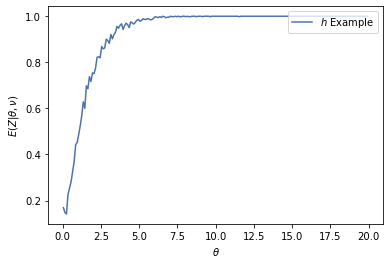

In [153]:
fig= plt.figure();ax=fig.add_subplot()

#Example:
plot_one_hist(Bprime=100000, thetamin=0,thetamax=20, nu=3,N=1,M=1,MLE=True, nbins=200, ax=ax)

### Plot the histogrammed approximations for the MLE vs non-MLE cases for a single value of $\mathbf{\nu}$

In [154]:
def plot_data_one_nu(Bprime, thetamin, thetamax, nu, D, MLE, 
              FONTSIZE=15,
              func=None,
              fgsize=(10, 6)):
    
    # make room for 6 sub-plots
    fig, ax = plt.subplots(nrows=2, 
                           ncols=3, 
                           figsize=fgsize)
    
    # padding
    plt.subplots_adjust(hspace=0.01)
    plt.subplots_adjust(wspace=0.20)
    
    # use flatten() to convert a numpy array of 
    # shape (nrows, ncols) to a 1-d array. 
    ax = ax.flatten()
    
    for j, (N, M) in enumerate(D):
        
        y, bb = make_hist_data(Bprime,
                              thetamin, thetamax,
                              nu, N, M,
                              nbins=200,
                              MLE=True)
    
        ax[j].set_xlim(thetamin, thetamax-5)
        ax[j].set_ylim(0, 1)
        ax[j].set_xlabel(r'$\theta$', fontsize=FONTSIZE)
        ax[j].set_ylabel(r'$E(Z|\theta, \nu)$', fontsize=FONTSIZE)
        
        x = (bb[1:]+bb[:-1])/2
        ax[j].plot(x, y, 'b', lw=2, label='$\mathbf{h}$, MLE', alpha=0.3)
        #h is histogram approximation

        y_nonMLE, bb_nonMLE = make_hist_data(Bprime,
                              thetamin, thetamax,
                              nu, N, M,
                              nbins=200,
                              MLE=False)
        
        
        x_nonMLE = (bb_nonMLE[1:]+bb_nonMLE[:-1])/2
        ax[j].plot(x_nonMLE, y_nonMLE, 'r', lw=2, label='$\mathbf{h}$, non-MLE',alpha=0.3)
        
        
        if func:
            p, _ = func(nu, N, M)
            ax[j].plot(x, p, 'r', lw=2, label='f')
            #f is model approximation
        
        ax[j].grid(True, which="both", linestyle='-')
        ax[j].text(10.1, 0.42, r'$N, M = %d, %d$' % (N, M), 
                   # fontsize=FONTSIZE
                  ) 

        ax[j].text(10.1, 0.30, r'$\nu = %5.1f$' % nu, 
                   # fontsize=FONTSIZE
                  ) 

        ax[j].legend(loc='upper right')
        
    # hide unused sub-plots
    for k in range(j+1, len(ax)):
        ax[k].set_visible(False)
    
    plt.tight_layout()
    plt.show()


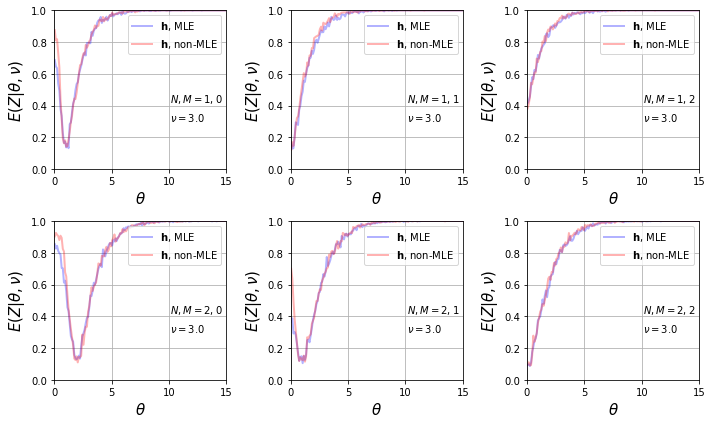

In [155]:
D = [ (N, M) for N in range(1,3) for M in range(3)]
plot_data_one_nu(Bprime=100000, thetamin=0, thetamax=20, nu=3, D=D, MLE=True)

### Plot the histogrammed approximations for the MLE vs non-MLE cases for multiple values of $\mathbf{\nu}$, indicating the dependence on the nuissance parameter

In [20]:
def plot_data(Bprime, thetamin, thetamax, D, MLE, 
              FONTSIZE=15,
              func=None,
              fgsize=(15, 13)):
    
    # make room for 6 sub-plots
    fig, ax = plt.subplots(nrows=6, 
                           ncols=2, 
                           figsize=fgsize)
    
    # padding
    plt.subplots_adjust(hspace=0.01)
    plt.subplots_adjust(wspace=0.20)
    
    # use flatten() to convert a numpy array of 
    # shape (nrows, ncols) to a 1-d array. 
    # ax = ax.flatten()
    
    for j, (N, M) in enumerate(D):
        NU1=1
        y, bb = make_hist_data(Bprime,
                              thetamin, thetamax,
                               NU1, N, M,
                              nbins=200,
                              MLE=True)
    
        ax[j, 0].set_xlim(thetamin, thetamax-5)
        ax[j, 0].set_ylim(0, 1)
        ax[j, 0].set_xlabel(r'$\theta$', fontsize=FONTSIZE)
        ax[j, 0].set_ylabel(r'$E(Z|\theta, \nu)$', fontsize=FONTSIZE)
        
        x = (bb[1:]+bb[:-1])/2
        ax[j, 0].plot(x, y, 'b', lw=2, label='$\mathbf{h}$, MLE', alpha=0.3)
        #h is histogram approximation

        y_nonMLE, bb_nonMLE = make_hist_data(Bprime,
                              thetamin, thetamax,
                              NU1, N, M,
                              nbins=200,
                              MLE=False)
        
        
        x_nonMLE = (bb_nonMLE[1:]+bb_nonMLE[:-1])/2
        ax[j, 0].plot(x_nonMLE, y_nonMLE, 'r', lw=2, label='$\mathbf{h}$, non-MLE',alpha=0.3)
        
        ax[j, 0].grid(True, which="both", linestyle='-')
        ax[j, 0].text(10.1, 0.42, r'$N, M = %d, %d$' % (N, M), 
                   # fontsize=FONTSIZE
                  ) 

        ax[j, 0].text(10.1, 0.30, r'$\nu = %5.1f$' % NU1, 
                   # fontsize=FONTSIZE
                  ) 

        ax[j, 0].legend(loc='upper right')
        ############define second nu value to see difference
        NU2=9
        y, bb = make_hist_data(Bprime,
                              thetamin, thetamax,
                               NU2, N, M,
                              nbins=200,
                              MLE=True)
    
        ax[j, 1].set_xlim(thetamin, thetamax-5)
        ax[j, 1].set_ylim(0, 1)
        ax[j, 1].set_xlabel(r'$\theta$', fontsize=FONTSIZE)
        ax[j, 1].set_ylabel(r'$E(Z|\theta, \nu)$', fontsize=FONTSIZE)
        
        x = (bb[1:]+bb[:-1])/2
        ax[j, 1].plot(x, y, 'b', lw=2, label='$\mathbf{h}$, MLE', alpha=0.3)
        #h is histogram approximation

        y_nonMLE, bb_nonMLE = make_hist_data(Bprime,
                              thetamin, thetamax,
                              NU1, N, M,
                              nbins=200,
                              MLE=False)
        
        
        x_nonMLE = (bb_nonMLE[1:]+bb_nonMLE[:-1])/2
        ax[j, 1].plot(x_nonMLE, y_nonMLE, 'r', lw=2, label='$\mathbf{h}$, non-MLE',alpha=0.3)
        
         
        ax[j, 1].grid(True, which="both", linestyle='-')
        ax[j, 1].text(10.1, 0.42, r'$N, M = %d, %d$' % (N, M), 
                   # fontsize=FONTSIZE
                  ) 

        ax[j, 1].text(10.1, 0.30, r'$\nu = %5.1f$' % NU2, 
                   # fontsize=FONTSIZE
                  ) 

        ax[j, 1].legend(loc='upper right')
        
        if func:
            p, _ = func(nu, N, M)
            ax[j, 0].plot(x, p, 'r', lw=2, label='f')
            #f is model approximation
        

        
    # hide unused sub-plots
    for k in range(j+1, len(ax)):
        ax[k].set_visible(False)
    
    plt.tight_layout()
    plt.show()

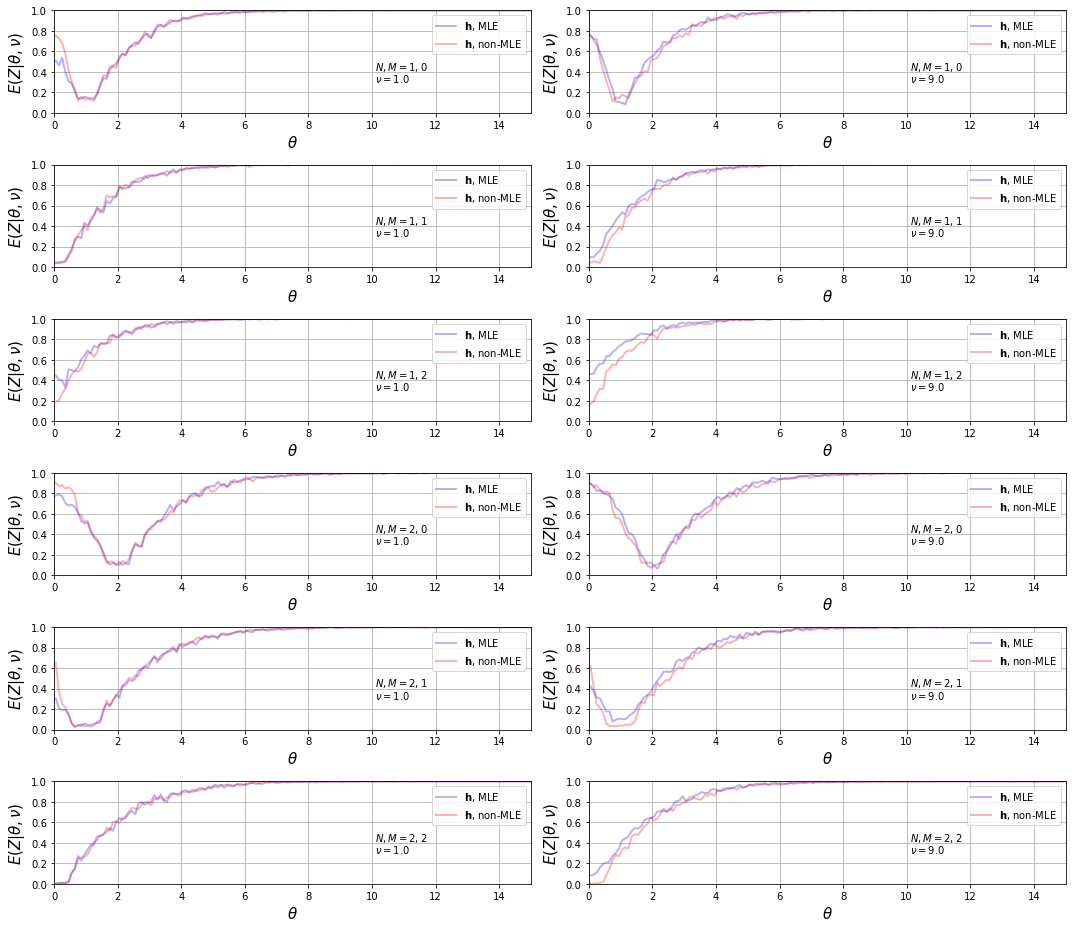

In [53]:
D = [ (N, M) for N in range(1,3) for M in range(3)]
plot_data(Bprime=100000, thetamin=0, thetamax=20, D=D, MLE=True)

--------------------
# ML

In [175]:
data = pd.read_csv('data/two_parameters_theta_0_20_1000k_Examples_MLE_True.csv', 
             # nrows=SUBSAMPLE,
             usecols=['Z','theta','nu', 'N', 'M']
            )
train_data, test_data = train_test_split(data, test_size=0.2)
#split the train data (0.8 of whole set) again into 0.8*0.8=0.64 of whole set
train_data, valid_data = train_test_split(train_data, test_size=0.2)

train_data = train_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)
test_data  = test_data.reset_index(drop=True)

target='Z'
source = ['theta','nu','N','M']

train_t, train_x = split_t_x(train_data, target=target, source=source)
valid_t, valid_x = split_t_x(valid_data, target=target, source=source)
test_t,  test_x  = split_t_x(test_data,  target=target, source=source)

n_iterations=50

### Define Model, which will approximate the expectation value above

In [172]:
class Model(nn.Module):
    
    def __init__(self, n_inputs=4, n_nodes=20, n_layers=5):

        # call constructor of base (or super, or parent) class
        super(Model, self).__init__()

        self.layers = []
        
        # create input layer
        self.layer0 = nn.Linear(n_inputs, n_nodes)
        self.layers.append(self.layer0)

        # create "hidden" layers
        for l in range(1, n_layers):
            cmd = 'self.layer%d = nn.Linear(%d, %d)' % \
            (l, n_nodes, n_nodes)
            exec(cmd)
            cmd = 'self.layers.append(self.layer%d)' % l
            exec(cmd)
          
        # create output layer
        cmd = 'self.layer%d = nn.Linear(%d, 1)' % (n_layers, n_nodes)
        exec(cmd)
        cmd = 'self.layers.append(self.layer%d)' % n_layers
        exec(cmd)

    # define (required) method to compute output of network
    def forward(self, x):
        y = x
        for layer in self.layers[:-1]:
            y = layer(y)
            y = torch.relu(y)
        y = self.layers[-1](y)
        y = torch.sigmoid(y)
        return y

model = Model()
print(model)

Model(
  (layer0): Linear(in_features=4, out_features=20, bias=True)
  (layer1): Linear(in_features=20, out_features=20, bias=True)
  (layer2): Linear(in_features=20, out_features=20, bias=True)
  (layer3): Linear(in_features=20, out_features=20, bias=True)
  (layer4): Linear(in_features=20, out_features=20, bias=True)
  (layer5): Linear(in_features=20, out_features=1, bias=True)
)


In [178]:
def average_quadratic_loss(f, t, x):
    # f and t must be of the same shape
    return  torch.mean((f - t)**2)
def average_loss(f, t):
    # f and t must be of the same shape
    return  torch.mean((f - t)**2)

def validate(model, avloss, inputs, targets):
    # make sure we set evaluation mode so that any training specific
    # operations are disabled.
    model.eval() # evaluation mode
    
    with torch.no_grad(): # no need to compute gradients wrt. x and t
        x = torch.from_numpy(inputs).float()
        t = torch.from_numpy(targets).float()
        # remember to reshape!
        o = model(x).reshape(t.shape)
    return avloss(o, t, x)


def get_features_training_batch(x, t, batch_size):
    # the numpy function choice(length, number)
    # selects at random "batch_size" integers from 
    # the range [0, length-1] corresponding to the
    # row indices.
    rows    = np.random.choice(len(x), batch_size)
    batch_x = x[rows]
    batch_t = t[rows]
    # batch_x.T[-1] = np.random.uniform(0, 1, batch_size)
    return (batch_x, batch_t)


def train(model, optimizer, avloss,
          batch_size, 
          n_iterations, traces, 
          step=50, window=50):
    
    # to keep track of average losses
    xx, yy_t, yy_v, yy_v_avg = traces
    
    n = len(valid_x)
    
    print('Iteration vs average loss')
    print("%10s\t%10s\t%10s" % \
          ('iteration', 'train-set', 'valid-set'))
    
    # training_set_features, training_set_targets, evaluation_set_features, evaluation_set_targets = get_data_sets(simulate_data=False, batchsize=batch_size)
    
    for ii in range(n_iterations):

        # set mode to training so that training specific 
        # operations such as dropout are enabled.
        model.train()
        
        # get a random sample (a batch) of data (as numpy arrays)
        # batch_x, batch_t = next(training_set_features()), next(training_set_targets())
        batch_x, batch_t = get_features_training_batch(train_x, train_t, batch_size)
        

        with torch.no_grad(): # no need to compute gradients 
            # wrt. x and t
            x = torch.from_numpy(batch_x).float()
            t = torch.from_numpy(batch_t).float()      

        # compute the output of the model for the batch of data x
        # Note: outputs is 
        #   of shape (-1, 1), but the tensor targets, t, is
        #   of shape (-1,)
        # In order for the tensor operations with outputs and t
        # to work correctly, it is necessary that they have the
        # same shape. We can do this with the reshape method.
        outputs = model(x).reshape(t.shape)
   
        # compute a noisy approximation to the average loss
        empirical_risk = avloss(outputs, t, x)
        
        # use automatic differentiation to compute a 
        # noisy approximation of the local gradient
        optimizer.zero_grad()       # clear previous gradients
        empirical_risk.backward()   # compute gradients
        
        # finally, advance one step in the direction of steepest 
        # descent, using the noisy local gradient. 
        optimizer.step()            # move one step
        
        if ii % step == 0:
#             batch_x_eval, batch_t_eval = next(evaluation_set_features()), next(evaluation_set_targets())
            
#             acc_t = validate(model, avloss, batch_x, batch_t) 
#             acc_v = validate(model, avloss, batch_x_eval, batch_t_eval)
            
            acc_t = validate(model, avloss, train_x[:n], train_t[:n]) 
            acc_v = validate(model, avloss, valid_x[:n], valid_t[:n])
            yy_t.append(acc_t)
            yy_v.append(acc_v)
            
            # compute running average for validation data
            len_yy_v = len(yy_v)
            if   len_yy_v < window:
                yy_v_avg.append( yy_v[-1] )
            elif len_yy_v == window:
                yy_v_avg.append( sum(yy_v) / window )
            else:
                acc_v_avg  = yy_v_avg[-1] * window
                acc_v_avg += yy_v[-1] - yy_v[-window-1]
                yy_v_avg.append(acc_v_avg / window)
                        
            if len(xx) < 1:
                xx.append(0)
                print("%10d\t%10.6f\t%10.6f" % \
                      (xx[-1], yy_t[-1], yy_v[-1]))
            else:
                xx.append(xx[-1] + step)
                    
                print("\r%10d\t%10.6f\t%10.6f\t%10.6f" % \
                          (xx[-1], yy_t[-1], yy_v[-1], yy_v_avg[-1]), 
                      end='')
            
    print()      
    return (xx, yy_t, yy_v, yy_v_avg)

def plot_average_loss(traces, ftsize=18,save_loss_plots=False):
    
    xx, yy_t, yy_v, yy_v_avg = traces
    
    # create an empty figure
    fig = plt.figure(figsize=(6, 4.5))
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)

    ax.set_title("Average loss")
    
    ax.plot(xx, yy_t, 'b', lw=2, label='Training')
    ax.plot(xx, yy_v, 'r', lw=2, label='Validation')
    #ax.plot(xx, yy_v_avg, 'g', lw=2, label='Running average')

    ax.set_xlabel('Iterations', fontsize=ftsize)
    ax.set_ylabel('average loss', fontsize=ftsize)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, which="both", linestyle='-')
    ax.legend(loc='upper right')
    if save_loss_plots:
        plt.savefig('images/loss_curves/IQN_'+N+T+'_Consecutive_2.png')
        print('\nloss curve saved in images/loss_curves/IQN_'+N+target+'_Consecutive.png')
    # if show_loss_plots:
    plt.show()

In [164]:
class RegularizedRegressionModel(nn.Module):
    #inherit from the super class
    def __init__(self, nfeatures, ntargets, nlayers, hidden_size, dropout):
        super().__init__()
        layers = []
        for _ in range(nlayers):
            if len(layers) ==0:
                #inital layer has to have size of input features as its input layer
                #its output layer can have any size but it must match the size of the input layer of the next linear layer
                #here we choose its output layer as the hidden size (fully connected)
                layers.append(nn.Linear(nfeatures, hidden_size))
                #batch normalization
                # layers.append(nn.BatchNorm1d(hidden_size))
                #Dropout seems to worsen model performance
                layers.append(nn.Dropout(dropout))
                #ReLU activation 
                layers.append(nn.ReLU())
            else:
                #if this is not the first layer (we dont have layers)
                layers.append(nn.Linear(hidden_size, hidden_size))
                # layers.append(nn.BatchNorm1d(hidden_size))
                #Dropout seems to worsen model performance
                layers.append(nn.Dropout(dropout))
                layers.append(nn.ReLU())
                #output layer:
        layers.append(nn.Linear(hidden_size, ntargets)) 

        # ONLY IF ITS A CLASSIFICATION, ADD SIGMOID
        layers.append(nn.Sigmoid())
            #we have defined sequential model using the layers in oulist 
        self.model = nn.Sequential(*layers)

    
    def forward(self, x):
        return self.model(x)

# Make a hyperparameter Tuning Workflow

Use Optuna ( [axriv:1907.10902](https://arxiv.org/pdf/1907.10902.pdf) ) for hyperparameter tuning

In [182]:


class Engine:
    """loss, training and evaluation"""
    def __init__(self, model, optimizer, batch_size):
                 #, device):
        self.model = model
        #self.device= device
        self.optimizer = optimizer
        self.batch_size=batch_size
        
    #the loss function returns the loss function. It is a static method so it doesn't need self
    # @staticmethod
    # def loss_fun(targets, outputs):
    #   tau = torch.rand(outputs.shape)
    #   return torch.mean(torch.where(targets >= outputs, 
    #                                   tau * (targets - outputs), 
    #                                   (1 - tau)*(outputs - targets)))

#     This loss combines a Sigmoid layer and the BCELoss in one single class. This version is more numerically stable than using a plain Sigmoid followed by a BCELoss as, 
#     by combining the operations into one layer

    def train(self, x, t):
        """the training function: takes the training dataloader"""
        self.model.train()
        final_loss = 0
        for iteration in range(n_iterations):
            self.optimizer.zero_grad()
            batch_x, batch_t = get_features_training_batch(x, t,  self.batch_size)#x and t are train_x and train_t

            # with torch.no_grad():
            inputs=torch.from_numpy(batch_x).float()
            targets=torch.from_numpy(batch_t).float()
            outputs = self.model(inputs)
            loss = average_quadratic_loss(outputs, targets, inputs)
            loss.backward()
            self.optimizer.step()
            final_loss += loss.item()

        return final_loss / self.batch_size
    
    def evaluate(self, x, t):
        """the training function: takes the training dataloader"""
        self.model.eval()
        final_loss = 0
        for iteration in range(n_iterations):
            batch_x, batch_t = get_features_training_batch(x, t,  self.batch_size)#x and t are train_x and train_t

            # with torch.no_grad():            
            inputs=torch.from_numpy(batch_x).float()
            targets=torch.from_numpy(batch_t).float()
            outputs = self.model(inputs)
            loss =average_quadratic_loss(outputs, targets, inputs)
            final_loss += loss.item()
        return final_loss / self.batch_size



EPOCHS=1
def run_train(params, save_model=False):
    """For tuning the parameters"""

    model =  RegularizedRegressionModel(
              nfeatures=train_x.shape[1], 
                ntargets=1,
                nlayers=params["nlayers"], 
                hidden_size=params["hidden_size"],
                dropout=params["dropout"]
                )
    # print(model)
    

    learning_rate= params["learning_rate"]
    optimizer_name = params["optimizer_name"]
    
    # optimizer = torch.optim.Adam(model.parameters(), lr=params["learning_rate"]) 
    
    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=learning_rate)
    
    eng=Engine(model, optimizer, batch_size=params["batch_size"])
    best_loss = np.inf
    early_stopping_iter=10
    early_stopping_coutner=0

    for epoch in range(EPOCHS):
        train_loss = eng.train(train_x, train_t)
        valid_loss=eng.evaluate(test_x, test_t)

        print(f"{epoch} \t {train_loss} \t {valid_loss}")
        if valid_loss<best_loss:
            best_loss=valid_loss
            if save_model:
                model.save(model.state_dict(), "model_m.bin")
        else:
            early_stopping_coutner+=1
        if early_stopping_coutner > early_stopping_iter:
            break
    return best_loss

# run_train()

def objective(trial):
    params = {
      "nlayers": trial.suggest_int("nlayers",1,13),      
      "hidden_size": trial.suggest_int("hidden_size", 2, 130),
      "dropout": trial.suggest_float("dropout", 0.1,0.5),
      "optimizer_name" : trial.suggest_categorical("optimizer_name", ["Adam", "RMSprop"]),
      "learning_rate": trial.suggest_float("learning_rate", 1e-5, 1e-2),
      "batch_size": trial.suggest_int("batch_size", 1000, 10000)

    }
    # all_losses=[]

    temp_loss = run_train(params,save_model=False)
    # all_losses.append(temp_loss)
    return temp_loss

def tune_hyperparameters():
    print('Getting best hyperparameters')
    study=optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=10)
    best_trial = study.best_trial
    print('best model parameters', best_trial.params)

    best_params=best_trial.params#this is a dictionary
    filename='best_params/best_params_Test_Trials.csv'
    param_df=pd.DataFrame({
                            'n_layers':best_params["nlayers"], 
                            'hidden_size':best_params["hidden_size"], 
                            'dropout':best_params["dropout"],
                            'optimizer_name':best_params["optimizer_name"],
                            'learning_rate': best_params["learning_rate"], 
                            'batch_size':best_params["batch_size"] },
                                    index=[0]
    )

    param_df.to_csv(filename)   

In [183]:
tune_hyperparameters()

[I 2022-11-07 17:16:20,866] A new study created in memory with name: no-name-9bcce66e-d655-42ca-bc9f-4ea6d8842991


Getting best hyperparameters


KeyboardInterrupt: 

In [184]:
BEST_PARAMS = pd.read_csv('best_params/best_params_Test_Trials.csv')
print(BEST_PARAMS)

n_layers = int(BEST_PARAMS["n_layers"]) 
hidden_size = int(BEST_PARAMS["hidden_size"])
dropout = float(BEST_PARAMS["dropout"])
optimizer_name = BEST_PARAMS["optimizer_name"].to_string().split()[1]
learning_rate =  float(BEST_PARAMS["learning_rate"])
batch_size = int(BEST_PARAMS["batch_size"])

   Unnamed: 0  n_layers  hidden_size  dropout optimizer_name  learning_rate  \
0           0         4           11  0.13208        RMSprop       0.006398   

   batch_size  
0        1000  


In [185]:
BATCHSIZE=batch_size
training_set_features, training_set_targets, evaluation_set_features, evaluation_set_targets = \
get_data_sets(simulate_data=False, batchsize=BATCHSIZE)

sample_x=next(training_set_features())#this is just to get the dimenstions of one batch
sample_y=next(training_set_targets())
#(batchsize,5) for mass
print('sample x shape', sample_x.shape)
print('sample t shape', sample_y.shape)

n_features = sample_x.shape[1]
print('\n')



model =  RegularizedRegressionModel(
    nfeatures=train_x.shape[1], 
    ntargets=1,
    nlayers=n_layers, 
    hidden_size=hidden_size, 
    dropout=dropout
    )

print(model)

sample x shape (1000, 4)
sample t shape (1000,)


RegularizedRegressionModel(
  (model): Sequential(
    (0): Linear(in_features=4, out_features=11, bias=True)
    (1): Dropout(p=0.1320798105984151, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=11, out_features=11, bias=True)
    (4): Dropout(p=0.1320798105984151, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=11, out_features=11, bias=True)
    (7): Dropout(p=0.1320798105984151, inplace=False)
    (8): ReLU()
    (9): Linear(in_features=11, out_features=11, bias=True)
    (10): Dropout(p=0.1320798105984151, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=11, out_features=1, bias=True)
    (13): Sigmoid()
  )
)


### Chose whose model (Ali or Harrison) and paramers and train

In [186]:
whose_model='Ali'

if whose_model=='Harrison':
    model=Model()
    optimizer     = torch.optim.Adam(model.parameters(), lr=int(1e-3)) 
elif whose_model=='Ali':
    n_layers = int(BEST_PARAMS["n_layers"]) 
    hidden_size = int(BEST_PARAMS["hidden_size"])
    dropout = float(BEST_PARAMS["dropout"])
    optimizer_name = BEST_PARAMS["optimizer_name"].to_string().split()[1]
    learning_rate =  float(BEST_PARAMS["learning_rate"])
    batch_size = int(BEST_PARAMS["batch_size"])
    model =  RegularizedRegressionModel(
        nfeatures=train_x.shape[1], 
        ntargets=1,
        nlayers=n_layers, 
        hidden_size=hidden_size, 
        dropout=dropout
        )
    optimizer = getattr(torch.optim, str(optimizer_name) )(model.parameters(), lr=learning_rate)

traces = ([], [], [], [])
traces_step = 100


n_iterations=20000
traces= train(model=model, 
              optimizer=optimizer, 
              avloss=average_quadratic_loss,
              batch_size=BATCHSIZE, 
              n_iterations=n_iterations, 
              traces=traces, 
              step=traces_step, 
              window=50)

Iteration vs average loss
 iteration	 train-set	 valid-set
         0	  0.161597	  0.161559
     19900	  0.057752	  0.057608	  0.057915


In [180]:
# n_iterations=10000
# BATCHSIZE=500
# traces= train(model=model, optimizer=optimizer, avloss=average_quadratic_loss,
#           batch_size=BATCHSIZE, 
#           n_iterations=n_iterations, traces=traces, 
#           step=traces_step, window=100)

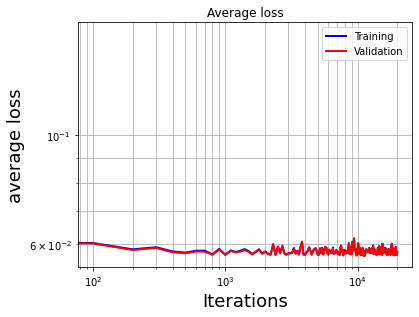

In [187]:
plot_average_loss(traces)

### Make sure the train df has the same ranges as the data you want to generate for evaluation

In [188]:
train_df = pd.read_csv('data/two_parameters_theta_0_20_1000k_Examples_MLE_True.csv', usecols=['theta','nu','N','M'])
train_df.describe()

,theta,nu,N,M
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,10.001455,9.996543,4.999657,4.999906
std,5.768938,5.774471,2.580935,2.582730
min,0.000011,0.000046,1.000000,1.000000
25%,5.012122,4.994961,3.000000,3.000000
50%,10.003773,9.988105,5.000000,5.000000
75%,14.997117,14.992853,7.000000,7.000000
max,19.999996,19.999982,9.000000,9.000000


In [189]:
def make_eval_data(Bprime, train_df, nu, N, M, nbins):
    #if MLE true, load the model that was trained on MLE data and vice versa
    # N, M = D
    # nbins=NBINS
    # thetamin,thetamax=0,20
    thetamin=train_df['theta'].min()
    thetamax=train_df['theta'].max()
    thetastep = (thetamax-thetamin) / nbins
    bb    = np.arange(thetamin, thetamax+thetastep, thetastep)#this is just making a vector of thetas
    X     = (bb[1:] + bb[:-1])/2
    tensor = torch.Tensor([[x, nu, N, M] for x in X])
    return tensor, X

### Look at an example of a "on-the-fly" generated evaluation data

In [190]:
eval_data_example, eval_bins_example =make_eval_data(Bprime=100,train_df=train_df,nu=3, N=0, M=1, nbins=300)
print(eval_data_example[:5])

tensor([[0.0333, 3.0000, 0.0000, 1.0000],
        [0.1000, 3.0000, 0.0000, 1.0000],
        [0.1667, 3.0000, 0.0000, 1.0000],
        [0.2333, 3.0000, 0.0000, 1.0000],
        [0.3000, 3.0000, 0.0000, 1.0000]])


In [191]:
eval_data_example.shape

torch.Size([300, 4])

In [192]:
def usemodel(Bprime, train_df, nu, N,M, MLE, nbins):
    #make evaluation data at those fixed nu, N, M values
    eval_data, eval_bins =make_eval_data(Bprime,train_df,nu, N,M, nbins)

    # if MLE==True:
    #     model=model
    #else load the model trained on non-MLE data
    model.eval()
    return model(eval_data).detach().numpy(), eval_bins

### Evaluate Trained model at this generated data

In [198]:
phat, phatbins = usemodel(Bprime=1000,train_df=train_df,nu=3, N=2, M=3, MLE=True, nbins=200)
print(phat[:5])

[[0.34422365]
 [0.3818369 ]
 [0.41292122]
 [0.47915617]
 [0.49093166]]


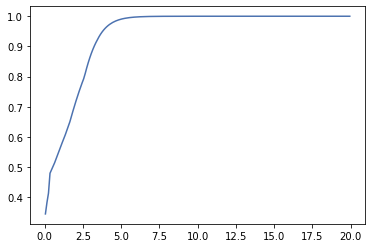

In [199]:
plt.plot(phatbins, phat)

### SAVE TRAINED MODEL (if it's good)

In [201]:
PATH='models/MLE_TRUE_Regressor_%sK_training_iter.pt' % str(n_iterations/1000)
torch.save(model.state_dict(),  PATH)

In [209]:
n_layers = int(BEST_PARAMS["n_layers"]) 
hidden_size = int(BEST_PARAMS["hidden_size"])
dropout = float(BEST_PARAMS["dropout"])
optimizer_name = BEST_PARAMS["optimizer_name"].to_string().split()[1]
learning_rate =  float(BEST_PARAMS["learning_rate"])
batch_size = int(BEST_PARAMS["batch_size"])
model =  RegularizedRegressionModel(
    nfeatures=train_x.shape[1], 
    ntargets=1,
    nlayers=n_layers, 
    hidden_size=hidden_size, 
    dropout=dropout
    )
model.load_state_dict(torch.load(PATH) )
#OR
#model=torch.load(PATH)#BUT HERE IT WILL BE A DICT (CANT BE EVALUATED RIGHT AWAY) DISCOURAGED!
print(model)

RegularizedRegressionModel(
  (model): Sequential(
    (0): Linear(in_features=4, out_features=11, bias=True)
    (1): Dropout(p=0.1320798105984151, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=11, out_features=11, bias=True)
    (4): Dropout(p=0.1320798105984151, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=11, out_features=11, bias=True)
    (7): Dropout(p=0.1320798105984151, inplace=False)
    (8): ReLU()
    (9): Linear(in_features=11, out_features=11, bias=True)
    (10): Dropout(p=0.1320798105984151, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=11, out_features=1, bias=True)
    (13): Sigmoid()
  )
)


### You could also evaluate the trained model on the validation data

In [210]:
# nbins=100
# thetamin=train_df['theta'].min()
# thetamax=train_df['theta'].max()
# thetastep = (thetamax-thetamin) / nbins
# bb    = np.arange(thetamin, thetamax+thetastep, thetastep)#this is just making a vector of thetas
# X     = (bb[1:] + bb[:-1])/2
eval_data=torch.Tensor(valid_x)
model.eval()
phat=model(eval_data).detach().numpy()

phat

array([[0.9991673 ],
       [0.97938824],
       [0.99973553],
       ...,
       [0.9999982 ],
       [0.9979261 ],
       [0.9999993 ]], dtype=float32)

In [211]:
def plot_data_one_nu(Bprime, thetamin, thetamax, nu, D, MLE, 
                     NBINS,
              FONTSIZE=15,
              func=None,
              fgsize=(10, 6)):
    
    # make room for 6 sub-plots
    fig, ax = plt.subplots(nrows=2, 
                           ncols=3, 
                           figsize=fgsize)
    
    # padding
    plt.subplots_adjust(hspace=0.01)
    plt.subplots_adjust(wspace=0.20)
    
    # use flatten() to convert a numpy array of 
    # shape (nrows, ncols) to a 1-d array. 
    ax = ax.flatten()
    
    for j, (N, M) in enumerate(D):
        
        y, bb = make_hist_data(Bprime,
                              thetamin, thetamax,
                              nu, N, M,
                              nbins=NBINS,
                              MLE=True)
    
        ax[j].set_xlim(thetamin-2, thetamax-5)
        ax[j].set_ylim(0, 1.3)
        ax[j].set_xlabel(r'$\theta$', fontsize=FONTSIZE)
        ax[j].set_ylabel(r'$E(Z|\theta, \nu)$', fontsize=FONTSIZE)
        
        x = (bb[1:]+bb[:-1])/2
        ax[j].plot(x, y, 'b', lw=2, label='$\mathbf{h}$, MLE', alpha=0.3)
        #h is histogram approximation

        y_nonMLE, bb_nonMLE = make_hist_data(Bprime,
                              thetamin, thetamax,
                              nu, N, M,
                              nbins=NBINS,
                              MLE=False)
        
        
        x_nonMLE = (bb_nonMLE[1:]+bb_nonMLE[:-1])/2
        ax[j].plot(x_nonMLE, y_nonMLE, 'r', lw=2, label='$\mathbf{h}$, non-MLE',alpha=0.3)
        
        
        if func:
            f, f_bins = func(Bprime, train_df, nu, N, M, MLE, nbins=NBINS)
            f=f.flatten()
            ax[j].plot(x, f, 'r', lw=2, label='$\mathbf{f}$ MLE')
            #f is model approximation
        
        ax[j].grid(True, which="both", linestyle='-')
        ax[j].text(10.1, 0.42, r'$N, M = %d, %d$' % (N, M), 
                   # fontsize=FONTSIZE
                  ) 

        ax[j].text(10.1, 0.30, r'$\nu = %5.1f$' % nu, 
                   # fontsize=FONTSIZE
                  ) 

        ax[j].legend(loc='upper right')
        
    # hide unused sub-plots
    for k in range(j+1, len(ax)):
        ax[k].set_visible(False)
    
    plt.tight_layout()
    plt.show()


Compare the histogrammed function $h(\theta, \nu, N, M)$ to the ML prediction functino $f(\theta, \nu, N, M)$ (which is trained to regress $Z$). 

In [212]:
def make_D(train_df):
    Nmin = train_df['N'].min()
    Nmax = train_df['N'].max()
    Mmin = train_df['M'].min()
    Mmax = train_df['M'].max()
    D = [ (N, M) for N in range(Nmin, Nmax) for M in range(Mmin, Mmax)]
    return D[:6]

D = make_D(train_df)
D

[(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6)]

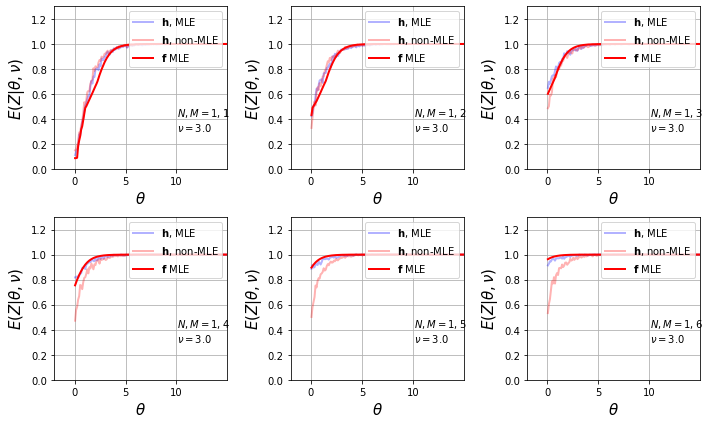

In [213]:
thetamin = train_df['theta'].min()
thetamax = train_df['theta'].max()
plot_data_one_nu(Bprime=100000, thetamin=thetamin, thetamax=thetamax, 
                 nu=3, D=D, MLE=True, NBINS=200, func=usemodel)